<a href="https://colab.research.google.com/github/OlegV12/NaturalLangProcessing/blob/Lesson_4/HW_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики



In [5]:
import pandas as pd


In [6]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [7]:
df = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/NLP/positive.csv', on_bad_lines='skip', delimiter=';', header=None)

In [8]:
df_n = pd.read_csv('/gdrive/MyDrive/Colab Notebooks/NLP/negative.csv', on_bad_lines='skip', delimiter=';', header=None)

In [9]:
df = df[[0, 3]]
df_n = df[[0, 3]]

In [10]:
df = pd.concat([df, df_n], ignore_index=True)

In [11]:
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [12]:
import re
import numpy as np
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from multiprocessing import Pool
from pymystem3 import Mystem

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
! pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 8.2 MB 6.8 MB/s 


In [15]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [16]:
words_regex = re.compile('\w+')

def find_words(text, regex = words_regex):
    text = re.sub(r'[a-zA-Z]+', '', text)
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')

# mystem = Mystem()
# def lemmatize(words, lemmer = mystem, stopwords = stopwords_list):
#     lemmas = lemmer.lemmatize(' '.join(words))
#     return [w for w in lemmas if not w in stopwords 
#             and w.isalpha()]

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

In [17]:
df.iloc[10][3]

'Люблю маму и папу!!!!а в остальное я так...-влюбляюсь, привязываюсь)))\xa0'

In [18]:
print(preprocess(df.iloc[10][3]))

['любить', 'мама', 'папа', 'остальной', 'влюбляться', 'привязываться']


In [19]:
preprocessed_text = list(tqdm(map(preprocess, df[3])))

0it [00:00, ?it/s]

In [20]:
df[3] = preprocessed_text
df.sample(3)

,0,3
131555,409362770472083456,"[наверняка, курс, взять, кредит, минимальный, пакет, документ, подсказать]"
96633,411028161640820736,"[обычный, утро, мурманск]"
181054,410380881727987712,"[конкурент, ещё, слизать]"


## Модель LDA


Первая модель, которую мы рассмотрим, LDA - латентное размещение Дирихле. Воспользуемся реализацией из библиотеки gensim.

In [21]:
!pip install -U gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 2.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [22]:
from gensim.models import *
from gensim import corpora

Модель использует векторное представление документов, например, мешок слов (bow), поэтому сперва создадим словарь:

In [23]:
dictionary = corpora.Dictionary(df[3])

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('tweet.dict')

Векторизуем документы:

In [24]:
corpus = [dictionary.doc2bow(text) for text in df[3]]
corpora.MmCorpus.serialize('tweet.model', corpus) 

Теперь можем обучать модель:

In [25]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

CPU times: user 5min 57s, sys: 4.55 s, total: 6min 2s
Wall time: 6min 9s


Посмотрим на получившиеся темы:

In [26]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(4,
  '0.262*"спасибо" + 0.249*"хороший" + 0.146*"человек" + 0.146*"самый" + 0.046*"наверное" + 0.043*"главное" + 0.038*"слушать" + 0.033*"работать" + 0.016*"получаться" + 0.003*"наоборот"'),
 (13,
  '0.438*"год" + 0.342*"новый" + 0.089*"тема" + 0.085*"ваш" + 0.000*"твиттер" + 0.000*"ждать" + 0.000*"давать" + 0.000*"последний" + 0.000*"назад" + 0.000*"скоро"'),
 (18,
  '0.659*"фотка" + 0.062*"поздний" + 0.049*"поддержка" + 0.000*"послать" + 0.000*"прислать" + 0.000*"фотография" + 0.000*"скорость" + 0.000*"оплачивать" + 0.000*"гаи" + 0.000*"штраф"'),
 (9,
  '0.441*"сегодня" + 0.375*"мочь" + 0.076*"место" + 0.035*"столько" + 0.029*"повод" + 0.013*"выпить" + 0.000*"пятница" + 0.000*"ахи" + 0.000*"ходить" + 0.000*"вечер"'),
 (15,
  '0.620*"всё" + 0.116*"думать" + 0.059*"найти" + 0.037*"серия" + 0.035*"прям" + 0.028*"группа" + 0.026*"рада" + 0.023*"поэтому" + 0.011*"пиздец" + 0.008*"искренне"'),
 (1,
  '0.420*"день" + 0.122*"ночь" + 0.083*"нравиться" + 0.080*"почему" + 0.077*"сон" + 0.062*

На полученные темы можно посмотреть, изобразив их на плоскости с помощью библиотеки __pyLDAvis__. Чтобы спроецировать темы на плоскость, внутри применяется PCA-разложение.

In [27]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=dcceae2be96eea0f2d5da059e14bb2e93eff8d085c1900d8eedc11c51de2cca0
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [28]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

%time vis_data = gensimvis.prepare(lda, corpus, dictionary, mds='mmds')
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


CPU times: user 24.7 s, sys: 328 ms, total: 25.1 s
Wall time: 37.1 s


Посмотрим на метрики качества получившейся модели: перплексию и среднюю когерентность:

In [30]:
print(lda.log_perplexity(corpus))


-27.512967762707163


In [31]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Персплексия:  1.125304148193274e-12


In [32]:
coherence_model_lda = CoherenceModel(model=lda, texts=df[3], dictionary=dictionary, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  -8.478334543914897


Теперь можно подобрать оптимальное количество тем, опираясь на значение метрик:

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

  0%|          | 0/5 [00:00<?, ?it/s]

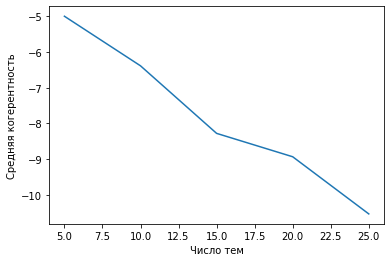

In [34]:
topics_list = [5, 10, 15, 20, 25]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=df[3], dictionary=dictionary, coherence='u_mass').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

Достаточно сложно интерпритировать тематики, из-за ограниченной длины сообщений в твиттере. В целом я бы выделил - планы, отзывы, настроение, новости.